In [1]:
import pickle as pkl
import pandas as pd
import json
import numpy as np
import networkx as nx
import random
from scipy import spatial
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 16})

In [2]:
lfm1b_user_info_filepath = '../../data/raw/LFM-1b_social/LFM-1b_users.txt'
lfm1b_user_additional_info_filepath = '../../data/raw/LFM-1b/LFM-1b_users_additional.txt'
lfm1b_user_genres_allmusic_filepath = '../../data/raw/LFM-1b_UGP/LFM-1b_UGP_weightedPC_allmusic.txt'
lfm1b_user_genres_freebase_filepath = '../../data/raw/LFM-1b_UGP/LFM-1b_UGP_weightedPC_freebase.txt'
input_edgelist_json_filepath = '../../data/raw/LFM-1b_user_friends/Klausner_CombinedUsers.json'
input_edgelist_csv_filepath = '../../data/raw/LFM-1b_social/LFM-1b_social_ties.txt'
lfm1b_user_artists_LEs_filepath = '../../data/raw/LFM-1b/LFM-1b_LEs.mat'

In [3]:
def create_lfm1b_users_df(lfm1b_users_filepath):
    lfm1b_users_df = pd.read_csv(lfm1b_users_filepath, sep='\t').drop(columns=['name'])
    return lfm1b_users_df

def create_edgelist_from_csv(input_csv_filepath, lfm1b_user_info_filepath, edge_users_in_lfm1b='both'):
    lfm1b_user_info_df = create_lfm1b_users_df(lfm1b_user_info_filepath)
    lfm1b_users_df = pd.read_csv('../../data/raw/LFM-1b_social/LFM-1b_social_ties.txt', sep='\t', header=None).drop([2], axis=1).rename(columns={0: 'user1', 1: 'user2'})
    lfm1b_users_df = lfm1b_users_df.rename(columns={'user1':'username'})
    lfm1b_users_df = lfm1b_users_df.merge(lfm1b_user_info_df[['username', 'user_id']], how='left', on='username').drop(['username'], axis=1)
    lfm1b_users_df = lfm1b_users_df.rename(columns={'user2':'username', 'user_id':'user1_id'})
    lfm1b_users_df = lfm1b_users_df.merge(lfm1b_user_info_df[['username', 'user_id']], how='left', on='username').drop(['username'], axis=1)
    lfm1b_users_df = lfm1b_users_df.rename(columns={'user_id':'user2_id'})
    lfm1b_users_df = lfm1b_users_df[~lfm1b_users_df.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True).astype('int32')
    return lfm1b_users_df

def create_graph(edgelist_df):
    G = nx.Graph()
    for edge in list(zip(edgelist_df.user1_id, edgelist_df.user2_id)):
        G.add_edge(edge[0], edge[1])
    return G

def create_random_edges_dict(G, n):
    random_edges_dict = {}
    nodes_list = list(G.nodes)
    edges_list = list(G.edges)
    num_negative_samples = int(0.001*(len(nodes_list)*len(nodes_list)/2 - len(edges_list)))
    print(num_negative_samples)
    for i in range(n):
        random_edges = []    
        while len(random_edges) < num_negative_samples:
            edge = random.sample(nodes_list, 2)
            if len(random_edges)%10000==0:
                print(len(random_edges))
            if edge[0]==edge[1] or (edge[0], edge[1]) in random_edges or (edge[1], edge[0]) in random_edges or (edge[0], edge[1]) in edges_list or (edge[1], edge[0]) in edges_list:
                continue
            random_edges.append((edge[0], edge[1]))
        random_edges_dict[i] = random_edges
    return random_edges_dict

# Create additional features
def calculate_relative_change_for_numeric_features(df, columns):
    for column in columns:
        df['relative_change_'+column] = df.apply(lambda x: relative_diff(x['user1_'+column], x['user2_'+column]), axis=1)
    return df

def calculate_cosine_similarity_for_vector_features(df, columns):
    for column in columns:
        df['cosine_similarity_'+column] = df.apply(lambda x: cosine_similarity(x['user1_'+column], x['user2_'+column]), axis=1)
    return df

def create_mask_for_categoric_features(df, columns):
    for column in columns:
        df['same_'+column] = (df['user1_'+column]==df['user2_'+column]).astype(int)
    return df

def calculate_jaccard_coefficient(df, G):
    df['jaccard_coefficient'] = df.apply(lambda x: get_jaccard_coefficient(G, x['user1_user_id'], x['user2_user_id']), axis=1)
    return df

def calculate_adamic_adar_coefficient(df, G):
    df['adamic_adar_coefficient'] = df.apply(lambda x: get_adamic_adar_index(G, x['user1_user_id'], x['user2_user_id']), axis=1)
    return df

def calculate_common_neighbors(df, G):
    df['common_neighbors'] = df.apply(lambda x: get_common_neighbors(G, x['user1_user_id'], x['user2_user_id']), axis=1)
    return df

def relative_diff(x, y):
    if x is None or y is None or x==-1 or y==-1:
        return None
    if max(x,y) == 0:
        return 0
    else:
        return abs((abs(x)-abs(y))/max(x,y))

def cosine_similarity(list1, list2):
    return 1 - spatial.distance.cosine(list1, list2)

def get_jaccard_coefficient(G, user1, user2):
    return list(nx.jaccard_coefficient(G, [(user1, user2)]))[0][2]

def get_adamic_adar_index(G, user1, user2):
    return list(nx.adamic_adar_index(G, [(user1, user2)]))[0][2]

def get_common_neighbors(G, user1, user2):
    return len(list(nx.common_neighbors(G, user1, user2)))

def extend_users_df_with_relational_features(users_df):
    users_df['freebase_nmf_array'] = users_df[['freebase_nmf_0', 'freebase_nmf_1', 'freebase_nmf_2', 'freebase_nmf_3', 'freebase_nmf_4', 'freebase_nmf_5', 'freebase_nmf_6', 'freebase_nmf_7', 'freebase_nmf_8', 'freebase_nmf_9', 'freebase_nmf_10', 'freebase_nmf_11', 'freebase_nmf_12', 'freebase_nmf_13', 'freebase_nmf_14', 'freebase_nmf_15', 'freebase_nmf_16', 'freebase_nmf_17', 'freebase_nmf_18', 'freebase_nmf_19']].values.tolist()
    users_df['allmusic_genre_array'] = users_df[['allmusic_rnb', 'allmusic_rap', 'allmusic_electronic', 'allmusic_rock', 'allmusic_new age', 'allmusic_classical', 'allmusic_reggae', 'allmusic_blues', 'allmusic_country', 'allmusic_world', 'allmusic_folk', 'allmusic_easy listening', 'allmusic_jazz', 'allmusic_vocal', "allmusic_children's", 'allmusic_punk', 'allmusic_alternative', 'allmusic_spoken word', 'allmusic_pop', 'allmusic_heavy metal']].values.tolist()
    users_df['UAM_nmf_array'] = users_df[['UAM_nmf_0', 'UAM_nmf_1', 'UAM_nmf_2', 'UAM_nmf_3', 'UAM_nmf_4', 'UAM_nmf_5', 'UAM_nmf_6', 'UAM_nmf_7', 'UAM_nmf_8', 'UAM_nmf_9', 'UAM_nmf_10', 'UAM_nmf_11', 'UAM_nmf_12', 'UAM_nmf_13', 'UAM_nmf_14', 'UAM_nmf_15', 'UAM_nmf_16', 'UAM_nmf_17', 'UAM_nmf_18', 'UAM_nmf_19']].values.tolist()
    users_df['allmusic_genre_array'] = users_df['allmusic_genre_array'].apply(lambda x: np.array(x))
    users_df['freebase_nmf_array'] = users_df['freebase_nmf_array'].apply(lambda x: np.array(x))
    users_df['UAM_nmf_array'] = users_df['UAM_nmf_array'].apply(lambda x: np.array(x))
    return users_df

def create_links_df(G, random_edges, users_df):
    edges_list = list(G.edges)
    users1_df = pd.DataFrame([x[0] for x in edges_list]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
    users2_df = pd.DataFrame([x[1] for x in edges_list]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
    friendship_df = pd.concat([users1_df, users2_df.set_index(users1_df.index)], axis=1)
    friendship_df['label'] = 1
    users1_df = pd.DataFrame([x[0] for x in random_edges]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user1_')
    users2_df = pd.DataFrame([x[1] for x in random_edges]).rename(columns={0:'user_id'}).merge(users_df, how='left', on='user_id').add_prefix('user2_')
    no_friendship_df = pd.concat([users1_df, users2_df.set_index(users1_df.index)], axis=1)
    no_friendship_df['label'] = 0
    links_df = pd.concat([friendship_df, no_friendship_df], axis=0, ignore_index=True)
    links_df = calculate_relative_change_for_numeric_features(links_df, ['age','playcount_lognorm','novelty_artist_avg_month','novelty_artist_avg_6months','novelty_artist_avg_year','mainstreaminess_avg_month','mainstreaminess_avg_6months','mainstreaminess_avg_year','mainstreaminess_global','relative_le_per_weekday1','relative_le_per_weekday2','relative_le_per_weekday3','relative_le_per_weekday4','relative_le_per_weekday5','relative_le_per_weekday6','relative_le_per_weekday7','relative_le_per_hour0','relative_le_per_hour1','relative_le_per_hour2','relative_le_per_hour3','relative_le_per_hour4','relative_le_per_hour5','relative_le_per_hour6','relative_le_per_hour7','relative_le_per_hour8','relative_le_per_hour9','relative_le_per_hour10','relative_le_per_hour11','relative_le_per_hour12','relative_le_per_hour13','relative_le_per_hour14','relative_le_per_hour15','relative_le_per_hour16','relative_le_per_hour17','relative_le_per_hour18','relative_le_per_hour19','relative_le_per_hour20','relative_le_per_hour21','relative_le_per_hour22','relative_le_per_hour23','cnt_listeningevents_lognorm','cnt_distinct_tracks_lognorm','cnt_distinct_artists_lognorm','cnt_listeningevents_per_week_lognorm','allmusic_weighted_average_diversity','allmusic_genre_coverage_diversity','allmusic_entropy_diversity','freebase_weighted_average_diversity','freebase_genre_coverage_diversity','freebase_entropy_diversity'])
    links_df = create_mask_for_categoric_features(links_df, ['country','gender','age_group','user_groups_freebase_weighted_average_diversity','user_groups_freebase_genre_coverage_diversity','user_groups_freebase_entropy_diversity','user_groups_allmusic_weighted_average_diversity','user_groups_allmusic_genre_coverage_diversity','user_groups_allmusic_entropy_diversity','user_groups_cnt_listeningevents_lognorm','user_groups_cnt_distinct_tracks_lognorm','user_groups_cnt_distinct_artists_lognorm','user_groups_cnt_listeningevents_per_week_lognorm','user_groups_playcount_lognorm','user_groups_novelty_artist_avg_month','user_groups_novelty_artist_avg_6months','user_groups_novelty_artist_avg_year','user_groups_mainstreaminess_avg_month','user_groups_mainstreaminess_avg_6months','user_groups_mainstreaminess_avg_year','user_groups_mainstreaminess_global'])
    links_df = calculate_cosine_similarity_for_vector_features(links_df, ['allmusic_genre_array', 'freebase_nmf_array', 'UAM_nmf_array'])
    links_df = links_df.select_dtypes(exclude=['object'])
    links_df = calculate_jaccard_coefficient(links_df, G)
    links_df = calculate_adamic_adar_coefficient(links_df, G)
    links_df = calculate_common_neighbors(links_df, G)
    return links_df

def create_and_store_dfs(G, random_edges_dict, users_df):
    for i in range(len(random_edges_dict)):
        links_df = create_links_df(G, random_edges_dict[i], users_df)
        links_df.to_csv('dataframes/links_dfs/'+ str(i) + '/links_df_full.csv')
        network_features_df = links_df[['user1_user_id', 'user2_user_id', 'jaccard_coefficient', 'adamic_adar_coefficient', 'common_neighbors', 'label']]
        demographic_features_df = pd.concat([links_df.filter(regex=("user1_user_id")), links_df.filter(regex=("user2_user_id")), links_df.filter(regex=(".*gender.*")), links_df.filter(regex=(".*age.*")), links_df.filter(regex=(".*country.*")), links_df.label], axis=1).drop(columns=['user1_allmusic_country', 'user2_allmusic_country'])
        demographic_features_df = demographic_features_df[demographic_features_df.columns.drop(list(demographic_features_df.filter(regex='allmusic')))]
        demographic_features_df = demographic_features_df[demographic_features_df.columns.drop(list(demographic_features_df.filter(regex='freebase')))]
        genre_features_df = pd.concat([links_df.filter(regex=("user1_user_id")), links_df.filter(regex=("user2_user_id")), links_df.filter(regex=(".*allmusic.*")), links_df.filter(regex=(".*freebase.*")), links_df.label], axis=1)
        genre_features_df = genre_features_df[genre_features_df.columns.drop(list(genre_features_df.filter(regex='diversity')))]
        listening_profile_features_df = pd.concat([links_df.filter(regex=("user1_user_id")), links_df.filter(regex=("user2_user_id")), links_df.filter(regex=(".*UAM.*")), links_df.label], axis=1)
        listening_characteristics_features_df = pd.concat([links_df.filter(regex=("user1_user_id")), links_df.filter(regex=("user2_user_id")), links_df.filter(regex=(".*mainstreaminess.*")), links_df.filter(regex=(".*novelty.*")), links_df.filter(regex=(".*diversity.*")), links_df.filter(regex=(".*cnt.*")), links_df.filter(regex=(".*playcount.*")), links_df.label], axis=1)
        network_features_df.to_csv('dataframes/links_dfs/' + str(i) + '/links_df_network_features.csv')
        demographic_features_df.to_csv('dataframes/links_dfs/' + str(i) + '/links_df_demographic_features.csv')
        genre_features_df.to_csv('dataframes/links_dfs/' + str(i) + '/links_df_genre_features.csv')
        listening_profile_features_df.to_csv('dataframes/links_dfs/' + str(i) + '/links_df_listening_profile_features.csv')
        listening_characteristics_features_df.to_csv('dataframes/links_dfs/' + str(i) + '/links_df_listening_characteristics_features.csv')

In [9]:
lfm1b_users_df = create_lfm1b_users_df(lfm1b_user_info_filepath)
edgelist_df = create_edgelist_from_csv(input_edgelist_csv_filepath, lfm1b_user_info_filepath)
G = create_graph(edgelist_df)
# uncomment this line when running for the first time
random_edges_dict = create_random_edges_dict(G, 10)
users_df = pd.read_csv('dataframes/users_df.csv', index_col=0)
users_df = extend_users_df_with_relational_features(users_df)
users_df_without_missing_values = pd.read_csv('dataframes/users_df_no_missing_values.csv', index_col=0)
users_df_without_missing_values = extend_users_df_with_relational_features(users_df_without_missing_values)
create_and_store_dfs(G, random_edges_dict, users_df)

69446
0


KeyboardInterrupt: 

In [50]:
degrees = [d for v, d in G.degree()]
G_conf=nx.configuration_model(degrees)
G_conf=nx.Graph(G_conf)
G_conf.remove_edges_from(nx.selfloop_edges(G_conf))

node_ids = list(G.nodes)
source_nodes = []
target_nodes = []
for edge in G_conf.edges:
    source_nodes.append(node_ids[edge[0]])
    target_nodes.append(node_ids[edge[1]])

In [56]:
user1_df = pd.DataFrame(source_nodes).rename(columns={0:'user_id'}).merge(users_df[['user_id', 'UAM_nmf_array', 'freebase_nmf_array']], on='user_id', how='left').rename(columns={'user_id':'user1_user_id', 'UAM_nmf_array':'user1_UAM_nmf_array', 'freebase_nmf_array':'user1_freebase_array'})
user2_df = pd.DataFrame(target_nodes).rename(columns={0:'user_id'}).merge(users_df[['user_id', 'UAM_nmf_array', 'freebase_nmf_array']], on='user_id', how='left').rename(columns={'user_id':'user2_user_id', 'UAM_nmf_array':'user2_UAM_nmf_array', 'freebase_nmf_array':'user2_freebase_array'})

In [58]:
lala_df = pd.concat([user1_df, user2_df], axis=1)
lala_df['cosine_similarity_'+'UAM_nmf_array'] = lala_df.apply(lambda x: cosine_similarity(x['user1_'+'UAM_nmf_array'], x['user2_'+'UAM_nmf_array']), axis=1)
lala_df['cosine_similarity_'+'freebase_array'] = lala_df.apply(lambda x: cosine_similarity(x['user1_'+'freebase_array'], x['user2_'+'freebase_array']), axis=1)

In [59]:
links_df = pd.read_csv('dataframes/links_dfs/0/links_df_full.csv', index_col=False).drop(columns=['Unnamed: 0'])
links_df = links_df[links_df.label==1]
# keep only users in the LCC
users_df = pd.read_csv('dataframes/users_df.csv', index_col=False).drop(columns=['Unnamed: 0'])
edges = list(zip(links_df.user1_user_id, links_df.user2_user_id))
G = nx.Graph()
for edge in edges:
    G.add_edge(edge[0], edge[1])
#G_lcc = [G.subgraph(c).copy() for c in nx.connected_components(G)][1]
#users_df = users_df[users_df['user_id'].isin(G_lcc.nodes)]
#links_df = links_df[(links_df['user1_user_id'].isin(G_lcc.nodes))&(links_df['user2_user_id'].isin(G_lcc.nodes))]
#df_subset = links_df[['cosine_similarity_freebase_nmf_array', 'cosine_similarity_UAM_nmf_array']]

users_df = users_df[users_df['user_id'].isin(G.nodes)]
links_df = links_df[(links_df['user1_user_id'].isin(G.nodes))&(links_df['user2_user_id'].isin(G.nodes))]
df_subset = links_df[['cosine_similarity_freebase_nmf_array', 'cosine_similarity_UAM_nmf_array']]

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.43791567911446017
0.3138983819876863
0.24022911662600632
0.2602977906186164


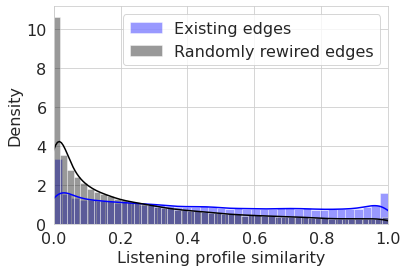

In [70]:
sns.distplot(pd.Series(df_subset['cosine_similarity_UAM_nmf_array'].values, name='Listening profile similarity'), color='blue', label='Existing edges', kde=True, norm_hist=True)
sns.distplot(lala_df['cosine_similarity_UAM_nmf_array'].values, color='black', label='Randomly rewired edges', kde=True, norm_hist=True)
plt.xlim(0, 1.0)
plt.legend();
plt.savefig('figures/existing_vs_random_listening_profile_similarity.pdf',dpi=300, bbox_inches = "tight")
print(df_subset['cosine_similarity_UAM_nmf_array'].mean())
print(df_subset['cosine_similarity_UAM_nmf_array'].std())
print(lala_df['cosine_similarity_UAM_nmf_array'].mean())
print(lala_df['cosine_similarity_UAM_nmf_array'].std())

/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/tduricic/.local/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.5202376409902363
0.27031649957035636
0.306458985575026
0.2364259717179838


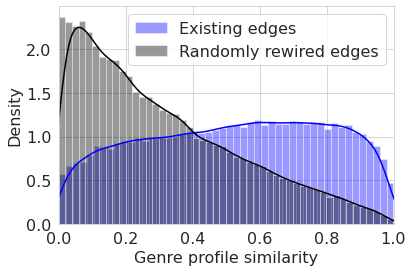

In [71]:
sns.distplot(pd.Series(df_subset['cosine_similarity_freebase_nmf_array'].values, name='Genre profile similarity'), color='blue', label='Existing edges', kde=True, norm_hist=True)
sns.distplot(lala_df['cosine_similarity_freebase_array'].values, color='black', label='Randomly rewired edges', kde=True, norm_hist=True)
plt.xlim(0, 1.0)
plt.legend();
plt.savefig('figures/existing_vs_random_genre_profile_similarity.pdf',dpi=300, bbox_inches = "tight")
print(df_subset['cosine_similarity_freebase_nmf_array'].mean())
print(df_subset['cosine_similarity_freebase_nmf_array'].std())
print(lala_df['cosine_similarity_freebase_array'].mean())
print(lala_df['cosine_similarity_freebase_array'].std())

In [73]:
links_df

,user1_user_id,user1_age,user1_playcount_lognorm,user1_novelty_artist_avg_month,user1_novelty_artist_avg_6months,user1_novelty_artist_avg_year,user1_mainstreaminess_avg_month,user1_mainstreaminess_avg_6months,user1_mainstreaminess_avg_year,user1_mainstreaminess_global,...,same_user_groups_mainstreaminess_avg_month,same_user_groups_mainstreaminess_avg_6months,same_user_groups_mainstreaminess_avg_year,same_user_groups_mainstreaminess_global,cosine_similarity_allmusic_genre_array,cosine_similarity_freebase_nmf_array,cosine_similarity_UAM_nmf_array,jaccard_coefficient,adamic_adar_coefficient,common_neighbors
0,7758024,17,10.893196,0.329145,0.044237,0.584282,0.000000,0.540323,0.000000,0.146582,...,1,0,0,1,0.968097,0.819403,0.256853,0.000000,0.000000,0
1,9484073,21,12.352102,0.172016,0.006126,0.340393,0.004582,0.388533,0.013787,0.026070,...,0,0,0,0,0.377638,0.554260,0.350323,0.035398,3.034131,4
2,9484073,21,12.352102,0.172016,0.006126,0.340393,0.004582,0.388533,0.013787,0.026070,...,0,1,0,0,0.395562,0.050326,0.224195,0.285714,0.515748,2
3,9484073,21,12.352102,0.172016,0.006126,0.340393,0.004582,0.388533,0.013787,0.026070,...,1,1,1,1,0.500778,0.700184,0.582176,0.000000,0.000000,0
4,9484073,21,12.352102,0.172016,0.006126,0.340393,0.004582,0.388533,0.013787,0.026070,...,0,1,0,0,0.451636,0.261624,0.214230,0.137931,2.943053,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78984,8527394,23,10.803852,0.251775,0.058367,0.458999,0.101784,0.499289,0.048271,0.173626,...,0,0,1,0,0.946470,0.480544,0.342888,0.000000,0.000000,0
78985,21735642,21,9.264071,0.219173,0.035488,0.394148,0.019513,0.524070,0.022988,0.156817,...,0,0,1,0,0.968135,0.764239,0.211016,0.000000,0.000000,0
78986,47994316,-1,5.786897,0.753788,0.009569,0.709335,0.044158,0.798262,0.000000,0.042093,...,1,0,1,1,0.892890,0.674235,0.852661,0.000000,0.000000,0
78987,47326836,16,9.252729,0.188876,0.045890,0.387811,0.000000,0.439598,0.093774,0.155150,...,1,1,0,0,0.931170,0.402268,0.738711,0.000000,0.000000,0


In [91]:
user_groups_dict = {
    'mainstreaminess_low':list(users_df[users_df.user_groups_mainstreaminess_global_low==1].user_id.values),
    'mainstreaminess_medium':list(users_df[users_df.user_groups_mainstreaminess_global_medium==1].user_id.values),
    'mainstreaminess_high':list(users_df[users_df.user_groups_mainstreaminess_global_high==1].user_id.values),
    'novelty_low':list(users_df[users_df.user_groups_novelty_artist_avg_6months_low==1].user_id.values),
    'novelty_medium':list(users_df[users_df.user_groups_novelty_artist_avg_6months_medium==1].user_id.values),
    'novelty_high':list(users_df[users_df.user_groups_novelty_artist_avg_6months_high==1].user_id.values),
    'diversity_low':list(users_df[users_df.user_groups_freebase_weighted_average_diversity_low==1].user_id.values),
    'diversity_medium':list(users_df[users_df.user_groups_freebase_weighted_average_diversity_medium==1].user_id.values),
    'diversity_high':list(users_df[users_df.user_groups_freebase_weighted_average_diversity_high==1].user_id.values)
}

In [101]:
keys = list(user_groups_dict.keys())
user_group_edges = {}
for i in range(len(keys)):
    for j in range(len(keys)):
        if j > i:
            continue
        user_group_edges[(keys[i], keys[j])] = []

In [99]:
for edge in G.edges:
    for user_group in user_groups

45

In [104]:
for column in users_df.columns:
    print(column)

user_id
country
age
gender
age_group
playcount_lognorm
novelty_artist_avg_month
novelty_artist_avg_6months
novelty_artist_avg_year
mainstreaminess_avg_month
mainstreaminess_avg_6months
mainstreaminess_avg_year
mainstreaminess_global
relative_le_per_weekday1
relative_le_per_weekday2
relative_le_per_weekday3
relative_le_per_weekday4
relative_le_per_weekday5
relative_le_per_weekday6
relative_le_per_weekday7
relative_le_per_hour0
relative_le_per_hour1
relative_le_per_hour2
relative_le_per_hour3
relative_le_per_hour4
relative_le_per_hour5
relative_le_per_hour6
relative_le_per_hour7
relative_le_per_hour8
relative_le_per_hour9
relative_le_per_hour10
relative_le_per_hour11
relative_le_per_hour12
relative_le_per_hour13
relative_le_per_hour14
relative_le_per_hour15
relative_le_per_hour16
relative_le_per_hour17
relative_le_per_hour18
relative_le_per_hour19
relative_le_per_hour20
relative_le_per_hour21
relative_le_per_hour22
relative_le_per_hour23
cnt_listeningevents_lognorm
cnt_distinct_tracks_lo